<a href="https://colab.research.google.com/github/ssbhatnagar/ANPR_Indian_Number_Plates/blob/main/ANPR_Inference_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing tensorflow and other imports

In [25]:
%tensorflow_version 1.15
import tensorflow as tf
print(tf.__version__)

!pip install numpy

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.2


In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

# change to working tensorflow directory on the drive
%cd '/content/gdrive/My Drive/models/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/models


In [27]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

### Installing object detection API

In [ ]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
%cd /content/gdrive/My Drive/models/research/
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/models/research/:/content/gdrive/My Drive/Tensorflow/models/research/slim'

!python setup.py build
!python setup.py install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.4).
python-pil is already the newest version (5.1.0-1ubuntu0.5).
python-tk is already the newest version (2.7.17-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
/content/gdrive/My Drive/models/research
running build
running build_py
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/eval_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_pb2.py -> build/lib/object_det

In [ ]:
!pip install --upgrade protobuf

In [ ]:
!pip install tf_slim
import os
%cd /content/gdrive/My Drive/models/research/object_detection
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/models/research/:/content/gdrive/My Drive/Tensorflow/models/research/slim'


/content/gdrive/My Drive/models/research/object_detection


In [ ]:
!pip install matplotlib

In [ ]:
!pip install tensorflow-object-detection-api

  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=756cba0fa8825b82e6e081e9e40547ee36690bd323a96b2bedeeddfa27efbe73
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-models-official 2.4.0 requires pyyaml>=5.1, but you have pyyaml 3.13 which is incompatible.
tf-models-official 2.4.0 requires tensorflow>=2.4.0, but you have tensorflow 1.15.2 which is incompatible.


In [29]:
import os
%cd /content/gdrive/My Drive/models/research/object_detection
os.environ['PYTHONPATH'] += ':/content/gdrive/My Drive/models/research/:/content/gdrive/My Drive/Tensorflow/models/research/slim'


/content/gdrive/My Drive/models/research/object_detection


## Implementing the model on test images

--- 5.269313812255859 seconds ---


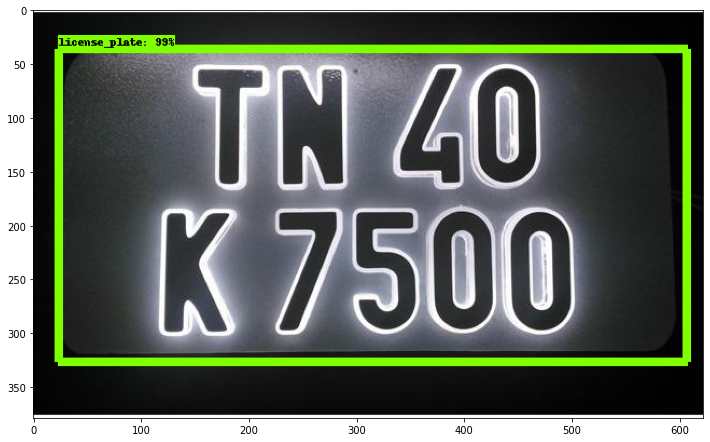

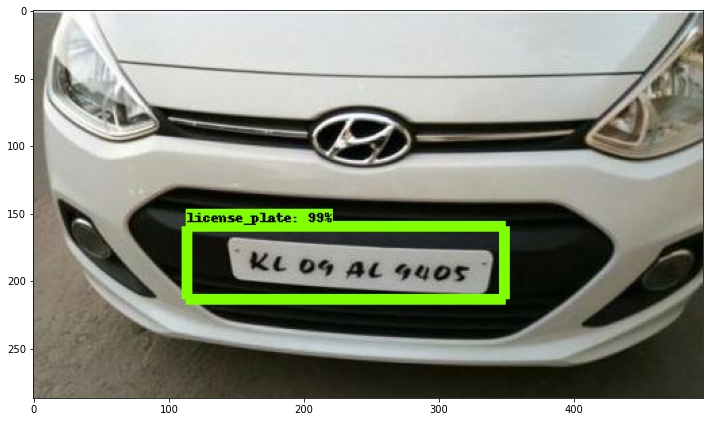

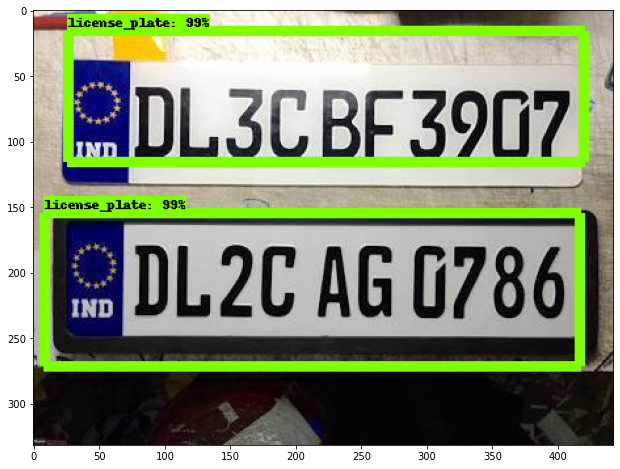

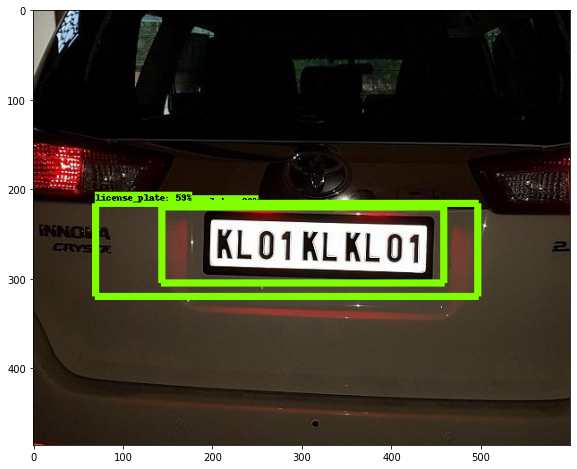

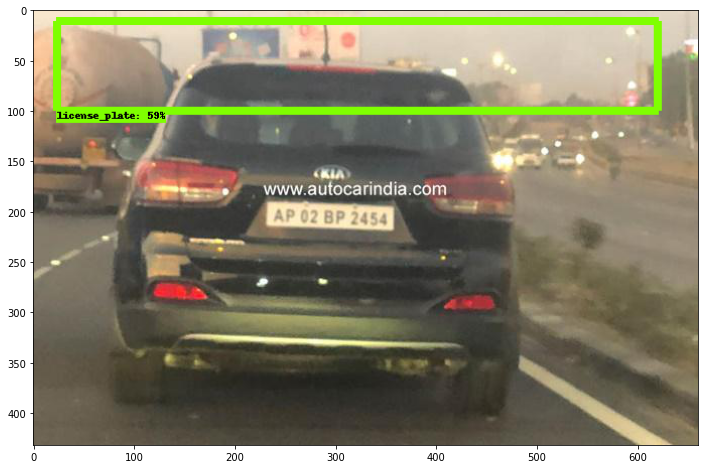

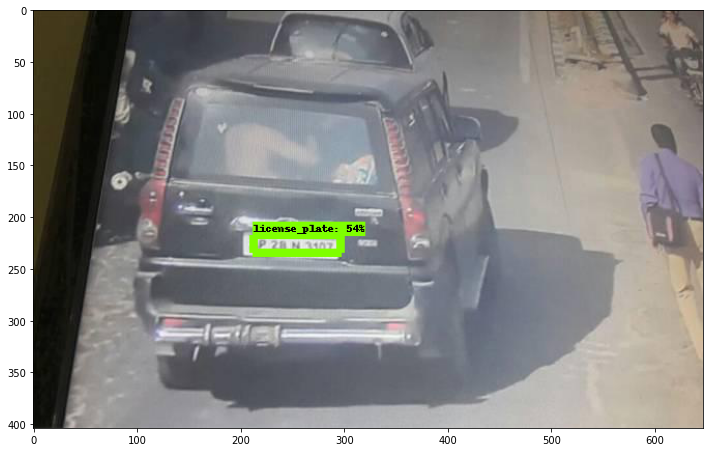

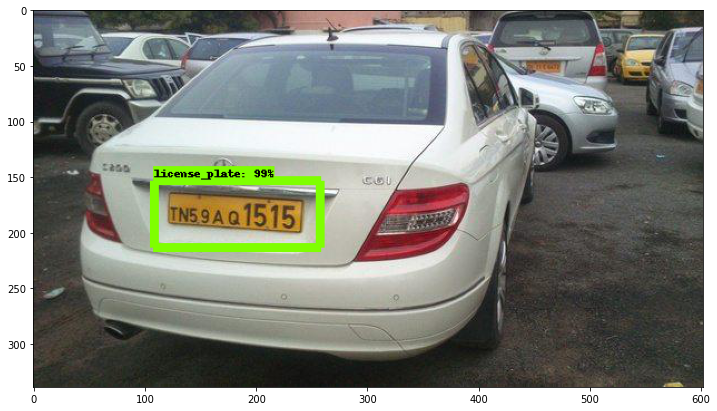

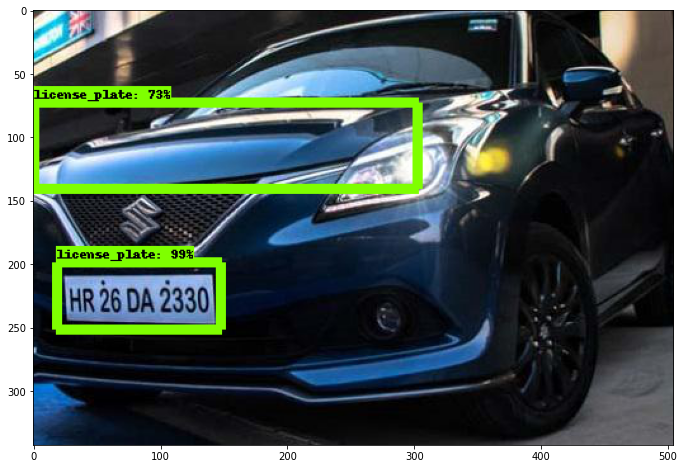

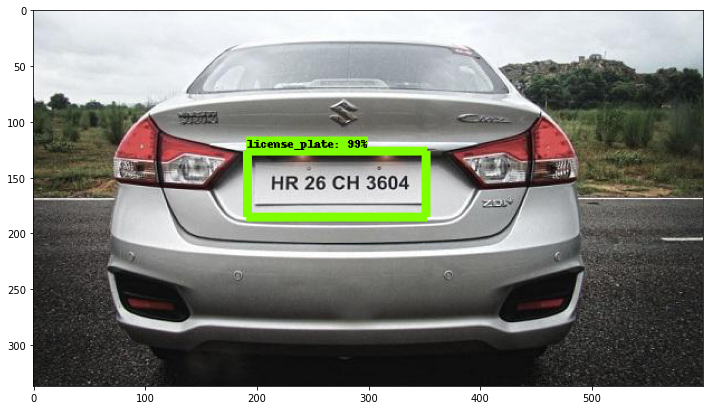

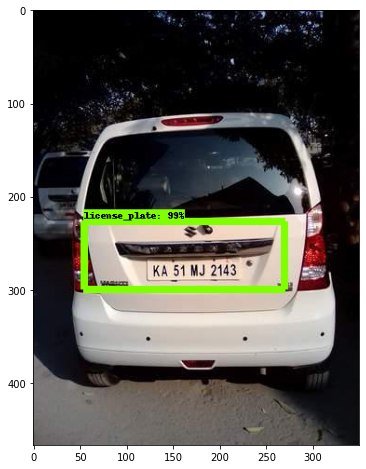

In [40]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util



# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")


PATH_TO_IGRAPH =  '/content/gdrive/MyDrive/models/research/object_detection/new_graph_f/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')  # labels are in training/object-detection.pbkt

NUM_CLASSES = 1  # we only are using one class at the moment (mask at the time of edit)

import time
start_time = time.time()

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_IGRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


PATH_TO_TEST_IMAGES_DIR = '/content/gdrive/MyDrive/models/research/object_detection/Test'
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'car{}.jpeg'.format(i)) for i in range(90, 100)]  # adjust range for # of images in folder

IMAGE_SIZE = (12, 8)


with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        i = 0
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=8)

            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)    
            #plt.savefig("outputs_new/detection_output{}.png".format(i))  
            i = i+1  

print("--- %s seconds ---" % (time.time() - start_time))

Inference time for 10 images is 5.26 seconds 
so for 1 image it will 0.5 seconds ie 2fps  